In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import os
from string2image.generate import Generator
from faker import Faker
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### We're going to implement text classification using Keras
I'm using [this](https://towardsdatascience.com/how-to-preprocess-character-level-text-with-keras-349065121089) blog post as a guide to prove out this concept.
### First let's generate our categorized data, similar to the other notebooks in this repository

In [2]:
fake = Faker()
data_sources = [
    fake.last_name,
    fake.phone_number,
    fake.company,
    fake.address,
    fake.ssn,
    fake.ascii_email
]
g = Generator(data_sources)

size = 1000
# When including the reverse we double our samples, the reverse is needed because we want to account for left-right and right-left subtractions
train_raw = list(g.random_data_gen(size))
test_raw = list(g.random_data_gen(size))
# Sloppy way of ensuring out test data does not appear in our train data
test_raw = [d for d in test_raw if d not in train_raw]

# Count how many testing samples are left.
print(len(test_raw), "test records")
print(test_raw[:4])

954 test records
[Data(value='+1-254-465-8511', label=1), Data(value='265-957-8613x8359', label=1), Data(value='Marsh', label=0), Data(value='brian19@hotmail.com', label=5)]


### Using Keras we can tokenize our text into characters and convert to numeric index values

In [3]:
# Keep text only separate for word embeddings
train_texts = [t for t, _ in train_raw]
test_texts = [t for t, _ in test_raw]

tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(train_texts)

train_sequences = tk.texts_to_sequences(train_texts)
test_sequences = tk.texts_to_sequences(test_texts)
test_sequences[:2]

[[45, 13, 10, 22, 15, 21, 10, 21, 18, 15, 10, 16, 15, 13, 13],
 [22, 18, 15, 10, 20, 15, 17, 10, 16, 18, 13, 19, 38, 16, 19, 15, 20]]

### One hot encode our labels, labels correspond to the function names defined above in the list `data_sources`

In [4]:
train_class_list = [x for _, x in train_raw]
test_class_list  = [x for _, x in test_raw]

train_classes = to_categorical(train_class_list)
test_classes = to_categorical(test_class_list)
test_classes[:2]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

### We're going to pad to make our strings consistent in length, truncating anything over length 64

In [5]:
input_size = 32

train_data = pad_sequences(train_sequences, maxlen=input_size, padding='post')
test_data = pad_sequences(test_sequences, maxlen=input_size, padding='post')

train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

test_data[:2]

array([[45., 13., 10., 22., 15., 21., 10., 21., 18., 15., 10., 16., 15.,
        13., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [22., 18., 15., 10., 20., 15., 17., 10., 16., 18., 13., 19., 38.,
        16., 19., 15., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

### Now we can define our model

In [6]:
vocab_size = len(tk.word_index)

embedding_layer = Embedding(vocab_size + 1,
                            vocab_size,
                            input_length=input_size)
num_classes = len(g.labels)
inputs = Input(shape=(input_size, ), name='input', dtype='int64')
x = embedding_layer(inputs)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)

x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)

x = Flatten()(x)

x = Dense(units=256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 32, 46)            2162      
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 64)            8896      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 64)             12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0     

### This technique performs suprisingly well at classifying data, if we were to throw in some similar looking data (e.g. first and last names we would have a harder time)

In [7]:
history = model.fit(train_data, train_classes,
          validation_data=(test_data, test_classes),
#           batch_size=128,
          epochs=10,
          verbose=2)

loss, accuracy = model.evaluate(test_data, test_classes)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/10
32/32 - 0s - loss: 1.5325 - accuracy: 0.4130 - val_loss: 0.9220 - val_accuracy: 0.7296
Epoch 2/10
32/32 - 0s - loss: 0.4331 - accuracy: 0.8870 - val_loss: 0.1750 - val_accuracy: 0.9717
Epoch 3/10
32/32 - 0s - loss: 0.0976 - accuracy: 0.9790 - val_loss: 0.1067 - val_accuracy: 0.9801
Epoch 4/10
32/32 - 0s - loss: 0.0569 - accuracy: 0.9850 - val_loss: 0.0858 - val_accuracy: 0.9832
Epoch 5/10
32/32 - 0s - loss: 0.0438 - accuracy: 0.9880 - val_loss: 0.0375 - val_accuracy: 0.9843
Epoch 6/10
32/32 - 0s - loss: 0.0182 - accuracy: 0.9930 - val_loss: 0.0159 - val_accuracy: 0.9979
Epoch 7/10
32/32 - 0s - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0131 - val_accuracy: 0.9969
Epoch 8/10
32/32 - 0s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9969
Epoch 9/10
32/32 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9979
Epoch 10/10
32/32 - 0s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9979
30/30 [============

### Let's take a look at some of the data flowing through the network

### First is the embedding layer and then the 1st convolution

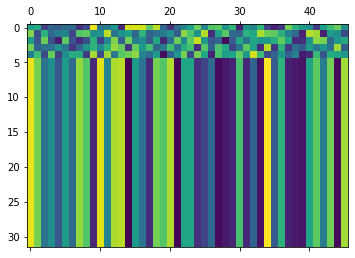

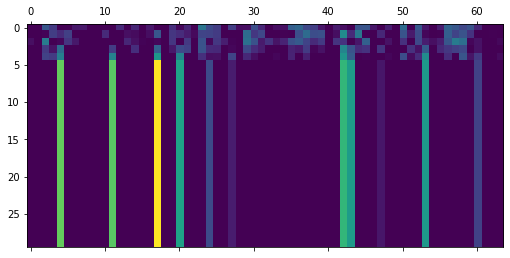

In [8]:
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data[:5]) 

embedding_activation = activations[1]
conv1d_activation = activations[2]

plt.matshow(embedding_activation[2, :, :], cmap='viridis')
plt.matshow(conv1d_activation[2, :, :], cmap='viridis')